<a href="https://colab.research.google.com/github/nat-tsang/computer-vision-bootcamp/blob/master/NT_WARG_CV_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


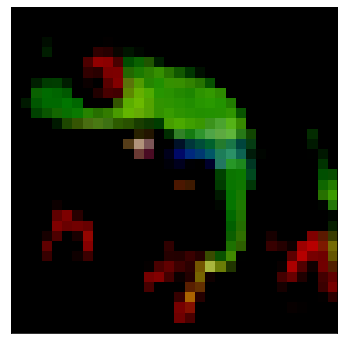

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os

import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from  torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))    
                                                   
])

dataset = datasets.CIFAR10(root='./data',train=True,transform=transform,download=True)
test_dataset = datasets.CIFAR10(root='./data',train=False,transform=transform,download=True)

#collect 10 classes 
classes = dataset.classes
class_count = {}

#loop through to see how many images are in each class
for v, index in dataset:
  label = classes[index]
  if label not in class_count:
    class_count[label] = 0
  class_count[label] +=1

torch.manual_seed(42) #ensures we get the same validation set each time (validation set contains 5000 images, 10% of the dataset)
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True) #shuffle true so that batches generated in each epoch are different
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True) #validation loader is only for evaluating the model
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True) # made pin memory true in these so that the data is pushed from the CPU to the GPU

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

show_batch(train_ds)



In [3]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [4]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), 
    nn.MaxPool2d(2,2)
)

for images, v in train_loader: 
  print('images.shape:', images.shape)
  out = simple_model(images)
  print('out.shape:', out.shape)
  break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [5]:
#MODEL
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch): 
    images, labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch) :
    images, labels = batch
    out = self(images) #Generate predictions 
    loss = F.cross_entropy(out, labels) #Calculate loss
    acc = accuracy(out, labels) #Calculate accuracy
    return {'val_loss' : loss.detach(), 'val_accuracy' : acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() #Combine losses
    batch_accs = [x['val_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() #Combine accuracies
    return {'val_loss': epoch_loss.item(),'val_accuracy': epoch_acc.item()}
  
  #summarizes end of epoch
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'], result['val_accuracy']))


In [6]:
def plot_losses(history):
  losses = [x['val_loss'] for x in history]
  plt.plot(losses, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
  accuracies = [x['val_accuracy'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

In [7]:
#training the model
input_size = 3*32*32
output_size = 10

In [8]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.conv import Conv2d
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
            
    def forward(self, xb):
        return self.network(xb)

In [9]:
for images, v in train_loader: 
  print('images.shape:', images.shape)
  out = simple_model(images)
  print('out.shape:', out.shape)
  break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [10]:
#defines utilities and moves data to GPU if available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
device = get_default_device()

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
model = CIFAR10Model
model = to_device(CIFAR10Model(), device)


opt_func = torch.optim.Adam

history = fit(10, 0.001, model, train_loader, val_loader, opt_func)

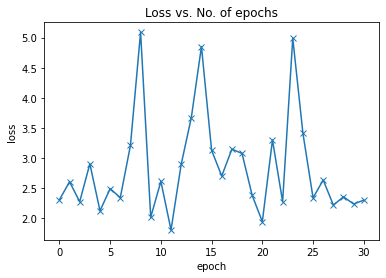

In [ ]:
plot_losses(history)


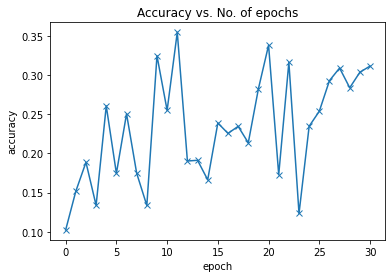

In [ ]:
plot_accuracies(history)